# **Taiwanese and Indonesian Presidential Inauguration Speech: What Does the Future Hold?**

**Inaugurational Speech: the case of Taiwan and Indonesia**

Course Instructor: Dr. Maciej Światła


> I Putu Agastya Harta Pratama - 472876; Si Tang Lin - 476912  
Faculty of Economic Sciences  
University of Warsaw  
Poland  
2026

## **Introduction**

This project analyzes presidential inauguration speeches from Taiwan and Indonesia. Both countries are Asian democracies, but they differ in political systems, culture, and historical background. By comparing the underlying topics from each candidates' inauguration inauguration speeches, we aim to understand whether they share similar political themes or express different visions for the future.

We use a topic modeling approach based on multilingual BERT, which allows texts in different languages to be analyzed within the same semantic space. This makes cross-country comparison of political discourse possible.

## **Specific Objective on Indonesian Speech**


Due to the language specifities, this partucular part of the project only works specifically on the Indonesian corpus. As with other steps, we conduct a topic modeling analysis on the Indonesian presidential inauguration speech, evaluate different BERTopic configurations (embedding models, UMAP, HDBSCAN, vectorizers, and nr_topics), and identify the optimal model based on coherence, similarity, and diversity diagnostics.





## Imports

In [ ]:
!pip install requests nltk spacy bertopic gensim tiktoken sentencepiece protobuf transformers tokenizers sentencepiece

In [ ]:
# for scrapper
import requests
from bs4 import BeautifulSoup
import os
import re

# others
from collections import Counter
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import math
import statistics
import pickle

# topic modelling

from nltk.tokenize import RegexpTokenizer
from itertools import combinations
from umap import UMAP
from hdbscan import HDBSCAN
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from sentence_transformers import SentenceTransformer, models
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import time
import pickle
import numpy as np
import pandas as pd
from itertools import product, combinations
import matplotlib.pyplot as plt


In [ ]:
# import sys
# print(sys.executable)

## Data Scrap

We collected the data using static webscrapping technique. The Indonesian corpus was obtained from the *Ministry of State Secretariat of the Republic of Indonesia.*

We focuses on one of the candidate
The scrapping process begins by defining the target URL and uses the `requests` library to fetch the webpage's HTML content. This content is then parsed by `BeautifulSoup` to enable easy navigation. The code specifically locates a `div` element with the class `reading_text`, which is presumed to contain the full speech text. Once found, `get_text` extracts and cleans the textual content, ensuring paragraphs are separated by newlines and extra whitespace is removed. Finally, this cleaned text is saved to a local file named `full_speech_indonesian.txt` for subsequent analysis without needing to re-scrape the website.

In [ ]:
url = "https://www.setneg.go.id/baca/index/pidato_presiden_prabowo_subianto_pada_sidang_paripurna_mpr_ri_dalam_rangka_pelantikan_presiden_dan_wakil_presiden_ri_terpilih_periode_2024_2029"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

speech_div = soup.find("div", class_="reading_text")

with open("full_speech_indonesian.txt", "w", encoding="utf-8") as f:
    f.write(speech_div.get_text(separator="\n", strip=True))  # pyright: ignore[reportOptionalMemberAccess]

## Data Import

The scrapped corpus are then loaded, and read into a single list

In [ ]:
with open("full_speech_indonesian.txt", "r") as fp:
    speech_uncleaned = fp.read()

data_full = [speech_uncleaned]
type(data_full)
text_full = data_full[0]

In [ ]:
text_full

'di Gedung Nusantara MPR/DPR/DPD RI, Senayan, Jakarta\nBismillahirahmanirahim.\nAssalamu’alaikum warahmatullahi wabarakatuh,\nSalam sejahtera untuk kita sekalian,\nSyalom,\nOm Swastiastu,\nNamo Buddhaya,\nSalam Kebajikan,\nRahayu, Rahayu.\nYang saya hormati dan yang saya muliakan,\nPresiden Republik Indonesia masa jabatan 2014-2024 Bapak Ir. Joko Widodo, beserta Ibu Iriana Joko Widodo;\nWakil Presiden Republik Indonesia masa jabatan 2019-2024 Bapak Prof. Dr. KH. Ma’ruf Amin, beserta Ibu Hj. Wuri Estu Ma’ruf Amin;\nWakil Presiden Republik Indonesia masa jabatan 2024-2029, Saudara Gibran Rakabuming Raka beserta Ibu Selvi Ananda Putri;\nPresiden Ke-6 Republik Indonesia Bapak Jenderal TNI Purn. Prof. Dr. H. Susilo Bambang Yudhoyono;\nWakil Presiden Ke-6 Republik Indonesia Bapak Jenderal TNI Purn. Try Sutrisno;\nWakil Presiden Ke-10 dan ke-12 Republik Indonesia, Bapak H. Muhammad Jusuf Kalla;\nWakil Presiden Ke-11 Republik Indonesia, Bapak Prof. Dr. Budiono;\nIbu Dra. Sinta Nuriyah Abdurrah

## Cleaning

In the cleaning process, we first standardize all newline characters and remove leading/trailing whitespace from the raw speech. We then split the cleaned speech into individual lines, discarding any empty ones, and proceed to filter these lines, keeping only the core content from a specific starting point (line 67) to eliminate metadata. The remaining content is joined into a single text body, where we normalize multiple spaces to single spaces. Finally, we split this text into individual sentences, ensuring each sentence has at least three words for meaningful analysis.

In [ ]:
# Normalize newlines to a single newline character and remove leading/trailing whitespace
speech_clean = speech_uncleaned.replace("\r\n", "\n").strip()

# 1) Split the cleaned speech into lines and remove empty lines
lines = [line.strip() for line in speech_clean.split("\n") if line.strip()]

print("Total lines:", len(lines))
print("5 lines before being cut:")
for l in lines[:5]:
    print("-", l)

# Keep only the lines starting from index 67 (to remove greetings/metadata)
content_lines = lines[67:]

print("\n5 lines pertama after cuts from line 68:")
for l in content_lines[:5]:
    print("-", l)

# Join the content lines into a single text body
text_body = " ".join(content_lines)
# Normalize multiple spaces to a single space and strip leading/trailing whitespace
text_body = re.sub(r"\s+", " ", text_body).strip()

print("\nPreview speech (after cut greetings):")
print(text_body[:500])

# === ADJUST 2: separate per sentence, bukan di-chunk per 80 kata ===

# Split the text body into raw sentences using common sentence terminators (. ! ?) followed by a space
raw_sentences = re.split(r'(?<=[.!?])\s+', text_body)

# Filter sentences to include only those with 3 or more words and strip whitespace
sentences = [s.strip() for s in raw_sentences if len(s.split()) >= 3]

print("\nHow many sentences:", len(sentences))
print("5 first sentences:")
for s in sentences[:5]:
    print("-", s)

Total baris: 174
5 baris pertama (sebelum dipotong):
- di Gedung Nusantara MPR/DPR/DPD RI, Senayan, Jakarta
- Bismillahirahmanirahim.
- Assalamu’alaikum warahmatullahi wabarakatuh,
- Salam sejahtera untuk kita sekalian,
- Syalom,

5 baris pertama SETELAH dipotong sampai line 68:
- Saudara-saudara sekalian,
- beberapa saat yang lalu di hadapan majelis yang terhormat ini, di hadapan seluruh rakyat Indonesia, dan yang terpenting dihadapan Tuhan Yang Mahakuasa Allah Swt., saya Prabowo Subianto dan Saudara Gibran Rakabuming Raka, telah mengucapkan sumpah untuk mempertahankan undang-undang dasar kita, untuk menjalankan semua undang-undang dan peraturan yang berlaku, untuk berbakti pada negara dan bangsa. Sumpah tersebut akan kami jalankan dengan sebaik-baiknya, dengan penuh rasa tanggung jawab dan dengan semua kekuatan yang ada pada jiwa dan raga kami. Kami akan menjalankan kepemimpinan pemerintah Republik Indonesia, kepemimpinan negara dan bangsa Indonesia dengan tulus, dengan mengutamakan 

In [ ]:
data = sentences
texts_for_bert = [t.lower() for t in data]

In [ ]:
texts = texts_for_bert

In [ ]:
lengths = [len(t) for t in data]

print("Jumlah dokumen:", len(data))
print("Min length:", min(lengths))
print("Max length:", max(lengths))
print("Mean length:", statistics.mean(lengths))
print("Median length:", statistics.median(lengths))

Jumlah dokumen: 150
Min length: 24
Max length: 438
Mean length: 136.00666666666666
Median length: 126.0


## Baseline BERT Models

Next, we use two different BERT models as the baseline before we applied hyperparameter tuning.  

 We chose the 'Multilingual-MiniLM-L12-H384' and  'paraphrase-multilingual-MiniLM-L12-v2' models primarily because they are multilingual, which is crucial for comparing presidential speeches across different languages, such as Indonesian and Chinese. Using multilingual models ensures that texts from various languages are embedded into the same semantic space, allowing for meaningful cross-country comparisons of political discourse.  

 For both models, the same chosen parameters are applied - specifically for the Indonesian corpus

### Multilingual-MiniLM-L12-H384

In [ ]:
from sentence_transformers import SentenceTransformer, models

tr = models.Transformer(
    "microsoft/Multilingual-MiniLM-L12-H384",
    tokenizer_args={"use_fast": False}
)
pool = models.Pooling(tr.get_word_embedding_dimension(), pooling_mode_mean_tokens=True)
embedding_model_1 = SentenceTransformer(modules=[tr, pool])

In [ ]:
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    metric="cosine",
    min_dist=0.05,
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=3,          # if too few topics, lower to 3
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

tokenizer = RegexpTokenizer(r"\w+")

tf_vectorizer = CountVectorizer(
    ngram_range=(1, 2),          # political phrases: "swasembada pangan", "wong cilik"
    max_df=0.5,
    min_df=2,
    tokenizer=tokenizer.tokenize,
    stop_words=['saudara','yang','dan','itu','ini','dengan','kepada','dari','sebagai','kita']              # Indonesian stopwords, can be extended if needed
)

ctfidf_model = ClassTfidfTransformer()
representation_model = KeyBERTInspired()

topic_model = BERTopic(
    embedding_model=embedding_model_1,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=tf_vectorizer,
    ctfidf_model=ctfidf_model,
    representation_model=representation_model,
    top_n_words=10,
    calculate_probabilities=True,
    nr_topics="auto"     # as in "optimal specification"
)

In [ ]:
# fit model
topics, probabilities = topic_model.fit_transform(texts_for_bert)

In [ ]:
topic_counts = pd.Series(topics).value_counts().sort_index()
print(topic_counts)

-1    28
 0    37
 1    36
 2    16
 3    11
 4     9
 5     5
 6     5
 7     3
Name: count, dtype: int64


In [ ]:
topic_info = topic_model.get_topic_info()
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,28,-1_banyak kebocoran_sekalian marilah_indonesia...,"[banyak kebocoran, sekalian marilah, indonesia...",[terlalu banyak saudara-saudara kita yang bera...
1,0,37,0_bung karno_berterima kasih_semua tingkatan_k...,"[bung karno, berterima kasih, semua tingkatan,...","[saudara-saudara sekalian, tantangan yang besa..."
2,1,36,1_harus akui_bangsa merdeka_semua komoditas_ko...,"[harus akui, bangsa merdeka, semua komoditas, ...","[tapi apakah kita sungguh-sungguh paham?, peme..."
3,2,16,2_sesingkat singkatnya_kedaulatan rakyat_sekal...,"[sesingkat singkatnya, kedaulatan rakyat, seka...",[kita merasa bangga bahwa kita diterima di kal...
4,3,11,3_tuhan mahabesar_allah swt_harus swasembada_b...,"[tuhan mahabesar, allah swt, harus swasembada,...",[kita berterima kasih kepada presiden megawati...
5,4,9,4_bung karno_sekalian juga_swasembada pangan_d...,"[bung karno, sekalian juga, swasembada pangan,...","[saya saksi, saya menterinya beliau, semua pih..."
6,5,5,5_pendiri bangsa_wong cilik_harus memberi_tapi...,"[pendiri bangsa, wong cilik, harus memberi, ta...","[soekarno, hatta, sjahrir, semua pendiri-pendi..."
7,6,5,6_penegakan hukum_semua tingkatan_tingkatan ha...,"[penegakan hukum, semua tingkatan, tingkatan h...",[hari ini kita punya tim medis yang bekerja di...
8,7,3,7_harus swasembada_swasembada energi_tidak mau...,"[harus swasembada, swasembada energi, tidak ma...",[kita tidak mau ikut pakta-pakta militer manap...


In [ ]:
topic_model.get_topic(4)

[('bung karno', np.float32(0.66058767)),
 ('sekalian juga', np.float32(0.6577107)),
 ('swasembada pangan', np.float32(0.6523476)),
 ('di gaza', np.float32(0.61850893)),
 ('wong cilik', np.float32(0.60644025)),
 ('di rafah', np.float32(0.60220444)),
 ('saya sudah', np.float32(0.57813203)),
 ('memberi makan', np.float32(0.5641238)),
 ('mereka mereka', np.float32(0.5637734)),
 ('semua pihak', np.float32(0.5602284))]

In [ ]:
topic_model.get_representative_docs(4)

['saya saksi, saya menterinya beliau, semua pihak dalam dan luar negeri, telepon terus, menekan beliau terus, minta lockdown , lockdown, lockdown .',
 'yang memberi makan adalah para petani di desa-desa, yang memberi makan adalah para nelayan, yang memberi makan adalah para pekerja, terus-menerus mereka yang mendirikan republik indonesia.',
 'saudara-saudara sekalian, juga semua subsidi bantuan kepada rakyat kita yang masih dalam keadaan susah, harus kita yakin subsidi-subsidi itu sampai kepada mereka yang membutuhkan.']

### Multilingual-MiniLM-L12-V2

In [ ]:
embedding_model_2 = SentenceTransformer(
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)

In [ ]:
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    metric="cosine",
    min_dist=0.05,
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=3,          # kalau topik terlalu sedikit, turunkan ke 3
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

tokenizer = RegexpTokenizer(r"\w+")

tf_vectorizer = CountVectorizer(
    ngram_range=(1, 2),          # frasa politik: "swasembada pangan", "wong cilik"
    max_df=0.5,
    min_df=2,
    tokenizer=tokenizer.tokenize,
    stop_words=['saudara','yang','dan','itu','ini','dengan','kepada','dari','sebagai','kita']              # nanti bisa ditambah stopwords bahasa Indonesia kalau perlu
)

ctfidf_model = ClassTfidfTransformer()
representation_model = KeyBERTInspired()

topic_model_2 = BERTopic(
    embedding_model=embedding_model_2,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=tf_vectorizer,
    ctfidf_model=ctfidf_model,
    representation_model=representation_model,
    top_n_words=10,
    calculate_probabilities=True,
    nr_topics="auto"     # seperti di "optimal specification"
)


In [ ]:
# fit model
topics_2, probabilities_2 = topic_model_2.fit_transform(texts_for_bert)

In [ ]:
topic_counts = pd.Series(topics_2).value_counts().sort_index()
print(topic_counts)

-1     55
 0     32
 1     14
 2     10
 3      6
 4      6
 5      6
 6      5
 7      4
 8      4
 9      4
 10     4
Name: count, dtype: int64


In [ ]:
topic_info_2 = topic_model_2.get_topic_info()
topic_info_2

,Topic,Count,Name,Representation,Representative_Docs
0,-1,55,-1_bangsa lain_kami_bangsa_harus berani,"[bangsa lain, kami, bangsa, harus berani, demo...","[dalam krisis, dalam keadaan genting, tidak ad..."
1,0,32,0_indonesia_harus berterima_presiden_berterima...,"[indonesia, harus berterima, presiden, berteri...",[kita bersyukur kepada presiden dan proklamato...
2,1,14,1_mari berani_harus berani_harus menghadapi_se...,"[mari berani, harus berani, harus menghadapi, ...","[saudara-saudara sekalian, tantangan yang besa..."
3,2,10,2_menjadi bangsa_adalah bangsa_bangsa bangsa_b...,"[menjadi bangsa, adalah bangsa, bangsa bangsa,...",[saya selalu mengajak saudara-saudaraku sebang...
4,3,6,3_kemiskinan_harus menghadapi_terlalu banyak_k...,"[kemiskinan, harus menghadapi, terlalu banyak,...",[ini adalah yang membahayakan masa depan kita ...
5,4,6,4_apakah sadar_sadar bahwa_tapi_sesuatu tidak,"[apakah sadar, sadar bahwa, tapi, sesuatu tida...","[saudara-saudara sekalian, kita tidak boleh me..."
6,5,6,5_pemimpin pemimpin_pemimpin_menjalankan kepem...,"[pemimpin pemimpin, pemimpin, menjalankan kepe...",[semua pejabat dari semua eselon dan semua tin...
7,6,5,6_demokrasi harus_harus demokrasi_demokrasi_me...,"[demokrasi harus, harus demokrasi, demokrasi, ...",[demokrasi kita harus demokrasi yang menghinda...
8,7,4,7_pengorbanan_kemerdekaan_memberi_karunia,"[pengorbanan, kemerdekaan, memberi, karunia, r...","[saudara-saudara sekalian, dan kita harus paha..."
9,8,4,8_komoditas harus_kemakmuran_semua kekayaan_se...,"[komoditas harus, kemakmuran, semua kekayaan, ...",[nilai tambah dari semua komoditas itu harus m...




1. Topic 1: Facing Challenges and Bravery
2. Topic 2: National Sovereignty and Statehood
3. Topic 3: Poverty, Corruption, and Misconduct
4. Topic 4: Awareness and Reality
5. Topic 5: Leadership and Governance
6. Topic 6: Democracy and National Will
7. Topic 7: Sacrifice, Independence, and Gifts
8. Topic 8: Prosperity, Wealth, and Economy
9. Topic 9: Energy and Geothermal Resources
10. Topic 10: Medical Assistance and Cooperation






In [ ]:
topic_model_2.get_topic(4)

[('apakah sadar', np.float32(0.54629964)),
 ('sadar bahwa', np.float32(0.52710176)),
 ('tapi', np.float32(0.46809828)),
 ('sesuatu tidak', np.float32(0.43868527)),
 ('melihat', np.float32(0.4349099)),
 ('sadar', np.float32(0.42311108)),
 ('untuk melihat', np.float32(0.4098381)),
 ('paham', np.float32(0.40272048)),
 ('sungguh', np.float32(0.4022464)),
 ('keadaan', np.float32(0.38486794))]

After obtaining the topics and qualitatively interpret those, we performed topic coherence, similarity, and diversity diagnostics on the baseline models to establish an initial understanding of topic quality before any hyperparameter tuning. These metrics allowed us to quantify how interpretable and distinct the topics were with default or minimal configurations, providing a crucial benchmark.

### Diagnostics - Topic Coherence

Coherence scores are used comparatively to assess the internal consistency of topic word sets across different embedding models and parameter configurations.

#### Coherence - Multilingual-MiniLM-L12-H384

In [ ]:
vectorizer = topic_model.vectorizer_model
tokens_2 = vectorizer.build_tokenizer()

def tokenize_uni_bi(doc: str):
    unigrams = tokens_2(doc.lower())
    bigrams = [f"{unigrams[i]} {unigrams[i+1]}" for i in range(len(unigrams)-1)]
    return unigrams + bigrams

texts_tokenised = [tokenize_uni_bi(doc) for doc in texts_for_bert]

top_n = 10  # must match your BERTopic top_n_words
top_words_dict = {}

for topic_id in topic_model.get_topics().keys():
    if topic_id == -1:
        continue
    words_scores = topic_model.get_topic(topic_id)
    top_words_dict[topic_id] = [w for w, _ in words_scores][:top_n]

dictionary = Dictionary(texts_tokenised)
dictionary.filter_extremes(no_below=2, no_above=0.5)
dictionary_vocab = set(dictionary.token2id.keys())

filtered_topics = {}
dropped_topics = []

for topic_id, words in top_words_dict.items():
    filtered_words = [w for w in words if w in dictionary_vocab]
    if len(filtered_words) < 2:
        dropped_topics.append(topic_id)
        continue
    filtered_topics[topic_id] = filtered_words

topics_for_gensim = list(filtered_topics.values())

In [ ]:
cm_umass = CoherenceModel(
    topics=topics_for_gensim,
    texts=texts_tokenised,
    dictionary=dictionary,
    coherence="u_mass"
)

cm_uci = CoherenceModel(
    topics=topics_for_gensim,
    texts=texts_tokenised,
    dictionary=dictionary,
    coherence="c_uci"
)

cm_npmi = CoherenceModel(
    topics=topics_for_gensim,
    texts=texts_tokenised,
    dictionary=dictionary,
    coherence="c_npmi"
)

coherence_df_1 = pd.DataFrame({
    "topic_id": list(filtered_topics.keys()),
    "top_words": list(filtered_topics.values()),
    "umass": cm_umass.get_coherence_per_topic(),
    "uci": cm_uci.get_coherence_per_topic(),
    "npmi": cm_npmi.get_coherence_per_topic(),
}).set_index("topic_id").sort_index()

display(coherence_df_1)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

,top_words,umass,uci,npmi
topic_id,,,,
0,"[bung karno, berterima kasih, semua tingkatan,...",-21.198480,-16.178321,-0.571687
1,"[semua komoditas, berhimpun, tidak mungkin, ti...",-21.940662,-14.914791,-0.511454
2,"[sesingkat singkatnya, kedaulatan rakyat, seka...",-17.235220,-13.349692,-0.434893
3,"[allah swt, harus swasembada, berterima kasih,...",-20.295223,-13.844644,-0.446994
4,"[bung karno, swasembada pangan, di gaza, wong ...",-21.589453,-15.403973,-0.526537
5,"[pendiri bangsa, wong cilik, harus memberi, ci...",-17.792144,-13.655553,-0.424829
6,"[penegakan hukum, semua tingkatan, tingkatan h...",-19.261325,-13.175716,-0.387082
7,"[harus swasembada, swasembada energi, tidak ma...",-17.228549,-12.290677,-0.367726


In [ ]:
avg_umass = coherence_df_1["umass"].mean()
avg_uci   = coherence_df_1["uci"].mean()
avg_npmi  = coherence_df_1["npmi"].mean()

print("\nAverage coherence:")
print(f"Average UMass coherence: {avg_umass:.4f}")
print(f"Average UCI coherence:   {avg_uci:.4f}")
print(f"Average NPMI coherence:  {avg_npmi:.4f}")


Average coherence:
Average UMass coherence: -19.5676
Average UCI coherence:   -14.1017
Average NPMI coherence:  -0.4589


#### Coherence - Multilingual-MiniLM-L12-v2

In [ ]:
vectorizer = topic_model_2.vectorizer_model
tokens_2 = vectorizer.build_tokenizer()

def tokenize_uni_bi(doc: str):
    unigrams = tokens_2(doc.lower())
    bigrams = [f"{unigrams[i]} {unigrams[i+1]}" for i in range(len(unigrams)-1)]
    return unigrams + bigrams

texts_tokenised = [tokenize_uni_bi(doc) for doc in texts_for_bert]

top_n = 10  # must match your BERTopic top_n_words
top_words_dict = {}

for topic_id in topic_model_2.get_topics().keys():
    if topic_id == -1:
        continue
    words_scores = topic_model_2.get_topic(topic_id)
    top_words_dict[topic_id] = [w for w, _ in words_scores][:top_n]

dictionary = Dictionary(texts_tokenised)
dictionary.filter_extremes(no_below=2, no_above=0.5)
dictionary_vocab = set(dictionary.token2id.keys())

filtered_topics = {}
dropped_topics = []

for topic_id, words in top_words_dict.items():
    filtered_words = [w for w in words if w in dictionary_vocab]
    if len(filtered_words) < 2:
        dropped_topics.append(topic_id)
        continue
    filtered_topics[topic_id] = filtered_words

topics_for_gensim = list(filtered_topics.values())

In [ ]:
cm_umass = CoherenceModel(
    topics=topics_for_gensim,
    texts=texts_tokenised,
    dictionary=dictionary,
    coherence="u_mass"
)

cm_uci = CoherenceModel(
    topics=topics_for_gensim,
    texts=texts_tokenised,
    dictionary=dictionary,
    coherence="c_uci"
)

cm_npmi = CoherenceModel(
    topics=topics_for_gensim,
    texts=texts_tokenised,
    dictionary=dictionary,
    coherence="c_npmi"
)

coherence_df_2 = pd.DataFrame({
    "topic_id": list(filtered_topics.keys()),
    "top_words": list(filtered_topics.values()),
    "umass": cm_umass.get_coherence_per_topic(),
    "uci": cm_uci.get_coherence_per_topic(),
    "npmi": cm_npmi.get_coherence_per_topic(),
}).set_index("topic_id").sort_index()

display(coherence_df_2)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

,top_words,umass,uci,npmi
topic_id,,,,
0,"[indonesia, harus berterima, presiden, berteri...",-13.652778,-12.287539,-0.379658
1,"[harus berani, harus menghadapi, sekalian tant...",-11.591744,-14.743054,-0.479459
2,"[menjadi bangsa, adalah bangsa, bangsa bangsa,...",-14.683870,-14.750247,-0.509131
3,"[kemiskinan, harus menghadapi, terlalu banyak,...",-9.883869,-10.906369,-0.288831
4,"[sadar bahwa, tapi, melihat, sadar, untuk meli...",-15.229962,-11.226021,-0.339129
5,"[pemimpin pemimpin, pemimpin, menjalankan kepe...",-13.706144,-14.089310,-0.453809
6,"[harus demokrasi, demokrasi, menjadi bangsa, p...",-11.874942,-15.249835,-0.510503
7,"[pengorbanan, kemerdekaan, memberi, karunia, r...",-13.854113,-12.491723,-0.374686
8,"[kemakmuran, semua kekayaan, semua komoditas, ...",-15.898744,-13.576859,-0.441733


In [ ]:
avg_umass = coherence_df_2["umass"].mean()
avg_uci   = coherence_df_2["uci"].mean()
avg_npmi  = coherence_df_2["npmi"].mean()

print("\nAverage coherence:")
print(f"Average UMass coherence: {avg_umass:.4f}")
print(f"Average UCI coherence:   {avg_uci:.4f}")
print(f"Average NPMI coherence:  {avg_npmi:.4f}")


Average coherence:
Average UMass coherence: -13.6832
Average UCI coherence:   -13.1753
Average NPMI coherence:  -0.4153


### Diagnostics - Topic Similarity

In [ ]:
def hellinger(p, q):
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))

def kl_divergence(p, q, eps=1e-12):
    p = np.clip(p, eps, None)
    q = np.clip(q, eps, None)
    return np.sum(p * np.log(p / q))

def js_divergence(p, q, eps=1e-12):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m, eps) + 0.5 * kl_divergence(q, m, eps)

#### Similarity - Multilingual-MiniLM-L12-H384

In [ ]:
#  get topic-term matrix from BERTopic
topic_info = topic_model.get_topic_info()  # includes -1
topic_ids = topic_info["Topic"].tolist()
ctfidf = topic_model.c_tf_idf_.toarray() if hasattr(topic_model.c_tf_idf_, "toarray") else np.asarray(topic_model.c_tf_idf_)

# drop -1 outliers
keep_mask = np.array([tid != -1 for tid in topic_ids])
kept_topic_ids = [tid for tid in topic_ids if tid != -1]
ctfidf_kept = ctfidf[keep_mask]

# normalise each topic vector to a probability distribution
row_sums = ctfidf_kept.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1.0
topic_distributions = ctfidf_kept / row_sums  # (n_topics x vocab)

In [ ]:
rows = []
for (i, tid_i), (j, tid_j) in combinations(list(enumerate(kept_topic_ids)), 2):
    p = topic_distributions[i]
    q = topic_distributions[j]
    rows.append({
        "topic_1": tid_i,
        "topic_2": tid_j,
        "hellinger": hellinger(p, q),
        "kl_divergence": kl_divergence(p, q),
        "js_divergence": js_divergence(p, q),
        "cosine_similarity": 1 - cosine(p, q)
    })

similarity_df_1 = pd.DataFrame(rows)
similarity_df_1

,topic_1,topic_2,hellinger,kl_divergence,js_divergence,cosine_similarity
0,0,1,0.752171,14.184555,0.404829,0.376195
1,0,2,0.784964,16.196469,0.445147,0.316334
2,0,3,0.882999,19.736347,0.559729,0.166955
3,0,4,0.866756,18.913398,0.541359,0.202952
4,0,5,0.900161,20.989164,0.600326,0.135789
5,0,6,0.915411,20.937168,0.606649,0.119590
6,0,7,0.910475,20.924874,0.603669,0.144439
7,1,2,0.868033,17.799678,0.527069,0.209313
8,1,3,0.968877,21.993516,0.653061,0.040704
9,1,4,0.900089,20.044030,0.569122,0.169991


In [ ]:
# compute average coherence across all clusters
avg_hellinger = similarity_df_1['hellinger'].mean()
avg_kl_divergence = similarity_df_1['kl_divergence'].mean()
avg_js_divergence = similarity_df_1['js_divergence'].mean()
avg_cosine_similarity = similarity_df_1['cosine_similarity'].mean()

print(f"Average Hellinger distance: {avg_hellinger:.4f}")
print(f"Average Kullback-Leibler divergence: {avg_kl_divergence :.4f}")
print(f"Average Jesen-Shannon divergence: {avg_js_divergence:.4f}")
print(f"Average cosine similarity: {avg_cosine_similarity:.4f}")

Average Hellinger distance: 0.9324
Average Kullback-Leibler divergence: 21.2285
Average Jesen-Shannon divergence: 0.6132
Average cosine similarity: 0.1050


#### Similarity - Multilingual-MiniLM-L12-v2

In [ ]:
#  get topic-term matrix from BERTopic
topic_info = topic_model_2.get_topic_info()  # includes -1
topic_ids = topic_info["Topic"].tolist()
ctfidf = topic_model_2.c_tf_idf_.toarray() if hasattr(topic_model_2.c_tf_idf_, "toarray") else np.asarray(topic_model_2.c_tf_idf_)

# drop -1 outliers
keep_mask = np.array([tid != -1 for tid in topic_ids])
kept_topic_ids = [tid for tid in topic_ids if tid != -1]
ctfidf_kept = ctfidf[keep_mask]

# normalise each topic vector to a probability distribution
row_sums = ctfidf_kept.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1.0
topic_distributions = ctfidf_kept / row_sums  # (n_topics x vocab)

In [ ]:
rows = []
for (i, tid_i), (j, tid_j) in combinations(list(enumerate(kept_topic_ids)), 2):
    p = topic_distributions[i]
    q = topic_distributions[j]
    rows.append({
        "topic_1": tid_i,
        "topic_2": tid_j,
        "hellinger": hellinger(p, q),
        "kl_divergence": kl_divergence(p, q),
        "js_divergence": js_divergence(p, q),
        "cosine_similarity": 1 - cosine(p, q)
    })

similarity_df_2 = pd.DataFrame(rows)
similarity_df_2

,topic_1,topic_2,hellinger,kl_divergence,js_divergence,cosine_similarity
0,0,1,0.828682,17.063594,0.486598,0.189277
1,0,2,0.817918,17.376277,0.478312,0.255978
2,0,3,0.899331,20.458364,0.581963,0.119257
3,0,4,0.908693,20.904305,0.592162,0.130059
4,0,5,0.911488,20.407485,0.589373,0.123476
5,0,6,0.921496,20.928763,0.603530,0.089614
6,0,7,0.912069,20.488218,0.592742,0.118142
7,0,8,0.905146,20.621808,0.586546,0.108768
8,0,9,0.924530,21.307848,0.616495,0.081795
9,0,10,0.884921,20.533356,0.569905,0.152930


In [ ]:
# compute average coherence across all clusters
avg_hellinger = similarity_df_2['hellinger'].mean()
avg_kl_divergence = similarity_df_2['kl_divergence'].mean()
avg_js_divergence = similarity_df_2['js_divergence'].mean()
avg_cosine_similarity = similarity_df_2['cosine_similarity'].mean()

print(f"Average Hellinger distance: {avg_hellinger:.4f}")
print(f"Average Kullback-Leibler divergence: {avg_kl_divergence :.4f}")
print(f"Average Jesen-Shannon divergence: {avg_js_divergence:.4f}")
print(f"Average cosine similarity: {avg_cosine_similarity:.4f}")

Average Hellinger distance: 0.9411
Average Kullback-Leibler divergence: 21.5508
Average Jesen-Shannon divergence: 0.6207
Average cosine similarity: 0.0847


Cosine 0.0837 is very low → on average, topic vectors barely overlap.

Interpretation: strong topic separation.

Hellinger 0.9428 is extremely high → topics are almost maximally different.

Interpretation: very strong separation.

Jensen 0.6229 is close to the upper bound 0.693 if natural log.

Interpretation: topics are very far apart.

Kullback 21.6 looks “huge”, but KL is not as interpretable on an absolute scale.

So there are genuily disctint themes within his speech, ngalang-ngablur

### Diagnostics - Topic Diversity

In [ ]:
def topic_diversity_bertopic(topic_model, top_n=10, include_outlier=False):
    topic_ids = list(topic_model.get_topics().keys())

    if not include_outlier:
        topic_ids = [t for t in topic_ids if t != -1]  # drop outlier topic

    all_top_words = []
    for t in topic_ids:
        words_scores = topic_model.get_topic(t)  # list of (word, score)
        if not words_scores:
            continue
        top_words = [w for w, _ in words_scores[:top_n]]
        all_top_words.extend(top_words)

    if len(all_top_words) == 0:
        return 0.0

    return len(set(all_top_words)) / len(all_top_words)

In [ ]:
# for later
div_m1 = topic_diversity_bertopic(topic_model, top_n=10, include_outlier=False)
div_m2 = topic_diversity_bertopic(topic_model_2, top_n=10, include_outlier=False)

print("Embedding model 1 diversity:", div_m1)
print("Embedding model 2 diversity:", div_m2)


Embedding model 1 diversity: 0.85
Embedding model 2 diversity: 0.9


# Hyperparameter Tuning - Both Models

In the hyperparameter tuning phase, we  explored a grid of various BERTopic parameters for both the 'Multilingual-MiniLM-L12-H384' and 'paraphrase-multilingual-MiniLM-L12-v2' embedding models. This involved iterating through different configurations for the CountVectorizer (ngram ranges, max_df, min_df), UMAP (n_neighbors, n_components, metric, min_dist), and HDBSCAN (min_cluster_size, metric, cluster_selection_method), as well as evaluating the impact of automatic topic reduction (nr_topics='auto').


For each combination, we fitted a BERTopic model to our Indonesian speech data and evaluated its performance using average UMass, UCI, and NPMI coherence scores.

In [ ]:
texts = texts_for_bert

stop_words = ['saudara','yang','dan','itu','ini','dengan','kepada','dari','sebagai','kita','saya']

tokenizer = RegexpTokenizer(r"\w+")
ctfidf_model = ClassTfidfTransformer()
representation_model = KeyBERTInspired()

In [ ]:
def st_from_hf(hf_name: str) -> SentenceTransformer:
    tr = models.Transformer(hf_name)
    pool = models.Pooling(tr.get_word_embedding_dimension(), pooling_mode_mean_tokens=True)
    return SentenceTransformer(modules=[tr, pool])

models_to_try = [
    "microsoft/Multilingual-MiniLM-L12-H384",
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
]

def load_embedder(name: str) -> SentenceTransformer:
    if name.startswith("microsoft/"):
        return st_from_hf(name)
    return SentenceTransformer(name)

In [ ]:
# chunk 3 — professor-style coherence functions (doc_freq / co_doc_freq / umass / uci / npmi)
def build_docs_as_sets(docs, tokenizer_fn):
    return [set(tokenizer_fn(doc.lower())) for doc in docs]

def doc_freq(word, docs_as_sets):
    return sum(1 for doc in docs_as_sets if word in doc)

def co_doc_freq(w1, w2, docs_as_sets):
    return sum(1 for doc in docs_as_sets if w1 in doc and w2 in doc)

def umass_coherence(words, docs_as_sets, eps=1e-12):
    scores_sum = 0.0
    n_pairs = 0
    for w1, w2 in combinations(words, 2):
        d_w1w2 = co_doc_freq(w1, w2, docs_as_sets)
        d_w2 = doc_freq(w2, docs_as_sets)
        if d_w2 == 0:
            continue
        scores_sum += np.log((d_w1w2 + eps) / d_w2)
        n_pairs += 1
    return scores_sum * 2 / (len(words) * (len(words) - 1)) if n_pairs > 0 else 0.0

def uci_coherence(words, docs_as_sets, n_docs, eps=1e-12):
    scores_sum = 0.0
    n_pairs = 0
    for w1, w2 in combinations(words, 2):
        p_w1 = doc_freq(w1, docs_as_sets) / n_docs
        p_w2 = doc_freq(w2, docs_as_sets) / n_docs
        p_w1w2 = co_doc_freq(w1, w2, docs_as_sets) / n_docs
        if p_w1 == 0 or p_w2 == 0:
            continue
        scores_sum += np.log((p_w1w2 + eps) / (p_w1 * p_w2))
        n_pairs += 1
    return scores_sum * 2 / (len(words) * (len(words) - 1)) if n_pairs > 0 else 0.0

def uci_npmi_coherence(words, docs_as_sets, n_docs, eps=1e-12):
    scores_sum = 0.0
    n_pairs = 0
    for w1, w2 in combinations(words, 2):
        p_w1 = doc_freq(w1, docs_as_sets) / n_docs
        p_w2 = doc_freq(w2, docs_as_sets) / n_docs
        p_w1w2 = co_doc_freq(w1, w2, docs_as_sets) / n_docs
        if p_w1w2 == 0:
            continue
        pmi = np.log((p_w1w2 + eps) / (p_w1 * p_w2))
        npmi = pmi / (-np.log(p_w1w2 + eps))
        scores_sum += npmi
        n_pairs += 1
    return scores_sum * 2 / (len(words) * (len(words) - 1)) if n_pairs > 0 else 0.0


In [ ]:
# chunk 4 — score a fitted bertopic model (avg across topics) using the professor coherence functions
def score_model(topic_model, docs, top_n=10):
    vec = topic_model.vectorizer_model
    tok_fn = vec.build_tokenizer()

    docs_as_sets = build_docs_as_sets(docs, tok_fn)
    n_docs = len(docs_as_sets)

    topic_info = topic_model.get_topic_info()
    topic_ids = topic_info.Topic[topic_info.Topic != -1].tolist()

    if len(topic_ids) == 0:
        return np.nan, np.nan, np.nan, 0

    per_topic = []
    for tid in topic_ids:
        ws = topic_model.get_topic(tid) or []
        words = [w for w, _ in ws][:top_n]
        if len(words) < 2:
            continue
        um = umass_coherence(words, docs_as_sets)
        uc = uci_coherence(words, docs_as_sets, n_docs)
        npmi = uci_npmi_coherence(words, docs_as_sets, n_docs)
        per_topic.append((um, uc, npmi))

    if len(per_topic) == 0:
        return np.nan, np.nan, np.nan, 0

    avg_umass = float(np.mean([x[0] for x in per_topic]))
    avg_uci = float(np.mean([x[1] for x in per_topic]))
    avg_npmi = float(np.mean([x[2] for x in per_topic]))
    return avg_umass, avg_uci, avg_npmi, len(per_topic)


In [ ]:
# chunk 5 — search grid (same idea as professor loop, but only the params you care about)
vectorisers = ["tf", "tfidf"]
ngram_ranges = [1, 3]  # professor wrote for ngram_range in [1] meaning (1,1) only; here we allow 1 and 2
max_dfs = [0.5, 1.0]
min_dfs = [1, 2]

n_neighbors_list = [15]
n_components_list = [5]
metric_umap_list = ["cosine"]
min_dist_list = [0.0, 0.05]

min_cluster_size_list = [3, 5]
metric_hdbscan_list = ["euclidean"]
cluster_selection_method_list = ["eom"]

nr_topics_flags = [True, False]  # True => "auto" like professor, False => no merging


In [ ]:
# chunk 6 — tuning loop (mimics professor: fit, compute metrics, append, save)
start = time.time()
results = []

for model_name in models_to_try:
    embedding_model = load_embedder(model_name)

    for ngram_range in ngram_ranges:
        for max_df in max_dfs:
            for min_df in min_dfs:
                for vectoriser in vectorisers:

                    if vectoriser == "tf":
                        vectorizer = CountVectorizer(
                            encoding="utf-8",
                            decode_error="strict",
                            lowercase=True,
                            ngram_range=(1, ngram_range),
                            max_df=max_df,
                            min_df=min_df,
                            max_features=None,
                            tokenizer=tokenizer.tokenize,
                            stop_words=stop_words
                        )
                    else:
                        vectorizer = TfidfVectorizer(
                            encoding="utf-8",
                            decode_error="strict",
                            lowercase=True,
                            ngram_range=(1, ngram_range),
                            max_df=max_df,
                            min_df=min_df,
                            max_features=None,
                            tokenizer=tokenizer.tokenize,
                            stop_words=stop_words
                        )

                    for n_neighbors in n_neighbors_list:
                        for n_components in n_components_list:
                            for metric_umap in metric_umap_list:
                                for min_dist in min_dist_list:

                                    umap_model = UMAP(
                                        n_neighbors=n_neighbors,
                                        n_components=n_components,
                                        metric=metric_umap,
                                        min_dist=min_dist,
                                        random_state=42
                                    )

                                    for min_cluster_size in min_cluster_size_list:
                                        for metric_hdbscan in metric_hdbscan_list:
                                            for cluster_selection_method in cluster_selection_method_list:

                                                hdbscan_model = HDBSCAN(
                                                    min_cluster_size=min_cluster_size,
                                                    metric=metric_hdbscan,
                                                    cluster_selection_method=cluster_selection_method,
                                                    prediction_data=True
                                                )

                                                for nr_topics_flag in nr_topics_flags:
                                                    nr_topics_value = "auto" if nr_topics_flag else None

                                                    topic_model = BERTopic(
                                                        embedding_model=embedding_model,
                                                        umap_model=umap_model,
                                                        hdbscan_model=hdbscan_model,
                                                        vectorizer_model=vectorizer,
                                                        ctfidf_model=ctfidf_model,
                                                        representation_model=representation_model,
                                                        top_n_words=10,
                                                        calculate_probabilities=True,
                                                        nr_topics=nr_topics_value
                                                    )

                                                    try:
                                                        topics, probs = topic_model.fit_transform(texts)

                                                        topic_ids = [t for t in set(topics) if t != -1]
                                                        n_topics = len(topic_ids)

                                                        umass, uci, npmi, n_topics_scored = score_model(topic_model, texts, top_n=10)

                                                        results.append([
                                                            model_name, ngram_range, max_df, min_df, vectoriser,
                                                            n_neighbors, n_components, metric_umap, min_dist,
                                                            min_cluster_size, metric_hdbscan, cluster_selection_method,
                                                            nr_topics_flag, umass, uci, npmi, n_topics, n_topics_scored
                                                        ])

                                                        with open("outputs/bertopic_optimisation_results.pkl", "wb") as f:
                                                            pickle.dump(results, f)

                                                        print(
                                                            model_name, ngram_range, max_df, min_df, vectoriser,
                                                            n_neighbors, n_components, metric_umap, min_dist,
                                                            min_cluster_size, metric_hdbscan, cluster_selection_method,
                                                            nr_topics_flag, umass, uci, npmi, n_topics
                                                        )

                                                    except Exception:
                                                        continue

end = time.time()
print(f"elapsed minutes: {(end-start)/60:.2f}")
print("runs kept:", len(results))


elapsed minutes: 3.12
runs kept: 240


In [ ]:
# chunk 7 — build results_df + normalise + rank (exactly like professor)
results_df = pd.DataFrame(results, columns=[
    "model","ngram_range","max_df","min_df","vectoriser",
    "n_neighbors","n_components","metric_umap","min_dist",
    "min_cluster_size","metric_hdbscan","cluster_selection_method",
    "nr_topics","umass","uci","npmi","n_topics","n_topics_scored"
])

metrics = ["umass","uci","npmi"]

normalized = results_df[metrics].apply(
    lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0.0
)

results_df["sum_normalised"] = normalized.sum(axis=1)

results_df.sort_values("sum_normalised", ascending=False).head(5)


,model,ngram_range,max_df,min_df,vectoriser,n_neighbors,n_components,metric_umap,min_dist,min_cluster_size,metric_hdbscan,cluster_selection_method,nr_topics,umass,uci,npmi,n_topics,n_topics_scored,sum_normalised
152,sentence-transformers/paraphrase-multilingual-...,1,1.0,1,tf,15,5,cosine,0.00,3,euclidean,eom,True,-13.086628,-7.550341,0.189719,3,3,2.023625
160,sentence-transformers/paraphrase-multilingual-...,1,1.0,1,tfidf,15,5,cosine,0.00,3,euclidean,eom,True,-13.630366,-7.914230,0.197376,3,3,2.020789
100,microsoft/Multilingual-MiniLM-L12-H384,3,1.0,1,tf,15,5,cosine,0.05,3,euclidean,eom,True,0.000000,0.000000,0.000000,8,8,1.999060
64,microsoft/Multilingual-MiniLM-L12-H384,3,0.5,1,tf,15,5,cosine,0.00,3,euclidean,eom,True,0.000000,0.000000,0.000000,7,7,1.999060
69,microsoft/Multilingual-MiniLM-L12-H384,3,0.5,1,tf,15,5,cosine,0.05,3,euclidean,eom,False,0.000000,0.000000,0.000000,8,8,1.999060


We later extracted the best parameters from the already tuned-models

In [ ]:
winner_idx = results_df["sum_normalised"].idxmax()
winner = results_df.loc[winner_idx]
winner

model                       sentence-transformers/paraphrase-multilingual-...
ngram_range                                                                 1
max_df                                                                    1.0
min_df                                                                      1
vectoriser                                                                 tf
n_neighbors                                                                15
n_components                                                                5
metric_umap                                                            cosine
min_dist                                                                  0.0
min_cluster_size                                                            3
metric_hdbscan                                                      euclidean
cluster_selection_method                                                  eom
nr_topics                                                       

## Selecting the Best Paramaters

In [ ]:
texts = texts_for_bert

stop_words = ['saudara','yang','dan','itu','ini','dengan','kepada','dari','sebagai','kita','saya']

embedding_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    metric="cosine",
    min_dist=0.05,
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=3,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

tokenizer = RegexpTokenizer(r"\w+")
tf_vectorizer = CountVectorizer(
    ngram_range=(1, 1),
    max_df=1.0,
    min_df=1,
    tokenizer=tokenizer.tokenize,
    stop_words=stop_words
)

ctfidf_model = ClassTfidfTransformer()
representation_model = KeyBERTInspired()

topic_model_3 = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=tf_vectorizer,
    ctfidf_model=ctfidf_model,
    representation_model=representation_model,
    top_n_words=10,
    calculate_probabilities=True,
    nr_topics="auto"
)

topics, probabilities = topic_model_3.fit_transform(texts)

topic_model_3.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,55,-1_bangsa_demokrasi_membutuhkan_perlu,"[bangsa, demokrasi, membutuhkan, perlu, pemimp...","[saudara-saudara, pemimpin yang berani pemimpi..."
1,0,32,0_indonesia_bersyukur_presiden_bangsa,"[indonesia, bersyukur, presiden, bangsa, repub...",[kami akan mengutamakan kepentingan bangsa ind...
2,1,14,1_berani_menghadapi_tantangan_marilah,"[berani, menghadapi, tantangan, marilah, rinta...","[saudara-saudara sekalian, tantangan yang besa..."
3,2,10,2_kedaulatan_berdaulat_bangsa_negara,"[kedaulatan, berdaulat, bangsa, negara, rakyat...","[saudara-saudara sekalian, kita harus mengerti..."
4,3,6,3_kemiskinan_penyimpangan_penyelewengan_korupsi,"[kemiskinan, penyimpangan, penyelewengan, koru...","[saudara-saudara sekalian, kita harus menghada..."
5,4,6,4_melihat_merasakan_tapi_realita,"[melihat, merasakan, tapi, realita, sadar, sun...",[apa kita sungguh-sungguh melihat gambaran yan...
6,5,6,5_pemimpin_kepemimpinan_pimpinan_pemerintahan,"[pemimpin, kepemimpinan, pimpinan, pemerintaha...",[semua pejabat dari semua eselon dan semua tin...
7,6,5,6_berdemokrasi_demokrasi_bangsa_kehendak,"[berdemokrasi, demokrasi, bangsa, kehendak, me...",[demokrasi kita harus demokrasi yang menghinda...
8,7,4,7_pengorbanan_kemerdekaan_hadiah_memberi,"[pengorbanan, kemerdekaan, hadiah, memberi, ka...","[saudara-saudara sekalian, kita paham, kita me..."
9,8,4,8_kemakmuran_kekayaan_ekonomi_penting,"[kemakmuran, kekayaan, ekonomi, penting, komod...",[nilai tambah dari semua komoditas itu harus m...


Qualitative Interpretation:
1. Topic 1: Embracing Challenges with Bravery
2. Topic 2: State Sovereignty and National Authority
3. Addressing social problems (e.g. poverty, corruption)
4. Awareness and perception of the current reality
5. Leadership standards
6. Democratic values and principles
7. Sacrifice for independence and blessings
8. Economic prosperity and wealth utilisation
9. Energy resources, self sufficiency
10. Medical support and collaboration efforts

## Diagnostics - Topic Coherence

To quantitatively verify our result, we also perform topics diagnostics on the already tuned models.

In [ ]:
vectorizer = topic_model_3.vectorizer_model
tokens_3 = vectorizer.build_tokenizer()

def tokenize_uni_bi(doc: str):
    unigrams = tokens_3(doc.lower())
    bigrams = [f"{unigrams[i]} {unigrams[i+1]}" for i in range(len(unigrams)-1)]
    return unigrams + bigrams

texts_tokenised = [tokenize_uni_bi(doc) for doc in texts_for_bert]

top_n = 10
top_words_dict = {}

for topic_id in topic_model_3.get_topics().keys():
    if topic_id == -1:
        continue
    words_scores = topic_model_3.get_topic(topic_id)
    top_words_dict[topic_id] = [w for w, _ in words_scores][:top_n]

dictionary = Dictionary(texts_tokenised)
dictionary.filter_extremes(no_below=2, no_above=0.5)
dictionary_vocab = set(dictionary.token2id.keys())

filtered_topics = {}
dropped_topics = []

for topic_id, words in top_words_dict.items():
    filtered_words = [w for w in words if w in dictionary_vocab]
    if len(filtered_words) < 2:
        dropped_topics.append(topic_id)
        continue
    filtered_topics[topic_id] = filtered_words

topics_for_gensim = list(filtered_topics.values())

In [ ]:
cm_umass = CoherenceModel(
    topics=topics_for_gensim,
    texts=texts_tokenised,
    dictionary=dictionary,
    coherence="u_mass"
)

cm_uci = CoherenceModel(
    topics=topics_for_gensim,
    texts=texts_tokenised,
    dictionary=dictionary,
    coherence="c_uci"
)

cm_npmi = CoherenceModel(
    topics=topics_for_gensim,
    texts=texts_tokenised,
    dictionary=dictionary,
    coherence="c_npmi"
)

coherence_df_3 = pd.DataFrame({
    "topic_id": list(filtered_topics.keys()),
    "top_words": list(filtered_topics.values()),
    "umass": cm_umass.get_coherence_per_topic(),
    "uci": cm_uci.get_coherence_per_topic(),
    "npmi": cm_npmi.get_coherence_per_topic(),
}).set_index("topic_id").sort_index()

display(coherence_df_3)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
TOKENIZERS_PARALLELISMTo disable this warning, you can either:
To disable this warning, you can either:
=(true | false)
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable 	- Avoid using `tokenizers` before the fork if possible
	

,top_words,umass,uci,npmi
topic_id,,,,
0,"[indonesia, bersyukur, presiden, bangsa, repub...",-9.267441,-8.559294,-0.203274
1,"[berani, menghadapi, tantangan, marilah, rinta...",-6.594633,-3.409780,0.142006
2,"[kedaulatan, berdaulat, bangsa, negara, kemerd...",-11.811903,-8.229031,-0.178771
3,"[kemiskinan, korupsi, terlalu, pemerintah, sek...",-8.646429,-5.483187,-0.028549
4,"[melihat, tapi, sadar, sungguh, paham, rakyat,...",-10.494314,-6.798334,-0.135961
5,"[pemimpin, kepemimpinan, pimpinan, pejabat, di...",-10.995516,-10.189375,-0.286317
6,"[demokrasi, bangsa, menjadi, menghindari, harus]",-8.317487,-4.506724,-0.045777
7,"[pengorbanan, kemerdekaan, memberi, karunia, m...",-12.812055,-10.441130,-0.281744
8,"[kemakmuran, kekayaan, ekonomi, komoditas, keb...",-11.637939,-8.023485,-0.156641


In [ ]:
avg_umass = coherence_df_3["umass"].mean()
avg_uci   = coherence_df_3["uci"].mean()
avg_npmi  = coherence_df_3["npmi"].mean()

print("\nAverage coherence:")
print(f"Average UMass coherence: {avg_umass:.4f}")
print(f"Average UCI coherence:   {avg_uci:.4f}")
print(f"Average NPMI coherence:  {avg_npmi:.4f}")


Average coherence:
Average UMass coherence: -9.7906
Average UCI coherence:   -7.7323
Average NPMI coherence:  -0.1530


## Diagnostics - Topic Similarity

In [ ]:
#  get topic-term matrix from BERTopic
topic_info = topic_model_3.get_topic_info()  # includes -1
topic_ids = topic_info["Topic"].tolist()
ctfidf = topic_model_3.c_tf_idf_.toarray() if hasattr(topic_model_3.c_tf_idf_, "toarray") else np.asarray(topic_model_3.c_tf_idf_)

# drop -1 outliers
keep_mask = np.array([tid != -1 for tid in topic_ids])
kept_topic_ids = [tid for tid in topic_ids if tid != -1]
ctfidf_kept = ctfidf[keep_mask]

# normalise each topic vector to a probability distribution
row_sums = ctfidf_kept.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1.0
topic_distributions = ctfidf_kept / row_sums  # (n_topics x vocab)

In [ ]:
rows = []
for (i, tid_i), (j, tid_j) in combinations(list(enumerate(kept_topic_ids)), 2):
    p = topic_distributions[i]
    q = topic_distributions[j]
    rows.append({
        "topic_1": tid_i,
        "topic_2": tid_j,
        "hellinger": hellinger(p, q),
        "kl_divergence": kl_divergence(p, q),
        "js_divergence": js_divergence(p, q),
        "cosine_similarity": 1 - cosine(p, q)
    })

similarity_df_3 = pd.DataFrame(rows)
similarity_df_3

,topic_1,topic_2,hellinger,kl_divergence,js_divergence,cosine_similarity
0,0,1,0.880550,18.713570,0.550114,0.161727
1,0,2,0.880596,18.453438,0.546555,0.209856
2,0,3,0.910544,19.945666,0.591753,0.126055
3,0,4,0.935445,20.718791,0.620526,0.097276
4,0,5,0.925982,20.432184,0.608421,0.127917
5,0,6,0.952981,20.888181,0.636575,0.075108
6,0,7,0.921636,20.454680,0.607050,0.120841
7,0,8,0.920386,20.111219,0.600678,0.108711
8,0,9,0.931189,20.998126,0.625588,0.085773
9,0,10,0.924675,20.438119,0.605734,0.115445


In [ ]:
# compute average coherence across all clusters
avg_hellinger = similarity_df_3['hellinger'].mean()
avg_kl_divergence = similarity_df_3['kl_divergence'].mean()
avg_js_divergence = similarity_df_3['js_divergence'].mean()
avg_cosine_similarity = similarity_df_3['cosine_similarity'].mean()

print(f"Average Hellinger distance: {avg_hellinger:.4f}")
print(f"Average Kullback-Leibler divergence: {avg_kl_divergence :.4f}")
print(f"Average Jesen-Shannon divergence: {avg_js_divergence:.4f}")
print(f"Average cosine similarity: {avg_cosine_similarity:.4f}")

Average Hellinger distance: 0.9402
Average Kullback-Leibler divergence: 21.0071
Average Jesen-Shannon divergence: 0.6186
Average cosine similarity: 0.0888


## Diagnostics - Topic Diversity

In [ ]:
def topic_diversity_bertopic(topic_model, top_n=10, include_outlier=False):
    topic_ids = list(topic_model.get_topics().keys())

    if not include_outlier:
        topic_ids = [t for t in topic_ids if t != -1]  # drop outlier topic

    all_top_words = []
    for t in topic_ids:
        words_scores = topic_model.get_topic(t)  # list of (word, score)
        if not words_scores:
            continue
        top_words = [w for w, _ in words_scores[:top_n]]
        all_top_words.extend(top_words)

    if len(all_top_words) == 0:
        return 0.0

    return len(set(all_top_words)) / len(all_top_words)

In [ ]:
# for later
div_m3 = topic_diversity_bertopic(topic_model_3, top_n=10, include_outlier=False)

print("Embedding model 1 diversity:", round(div_m3, 4))

Embedding model 1 diversity: 0.8636


In [ ]:
topic_model_3.save("topic_model_id_v3", serialization="pickle")

2026-01-21 23:11:34,433 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


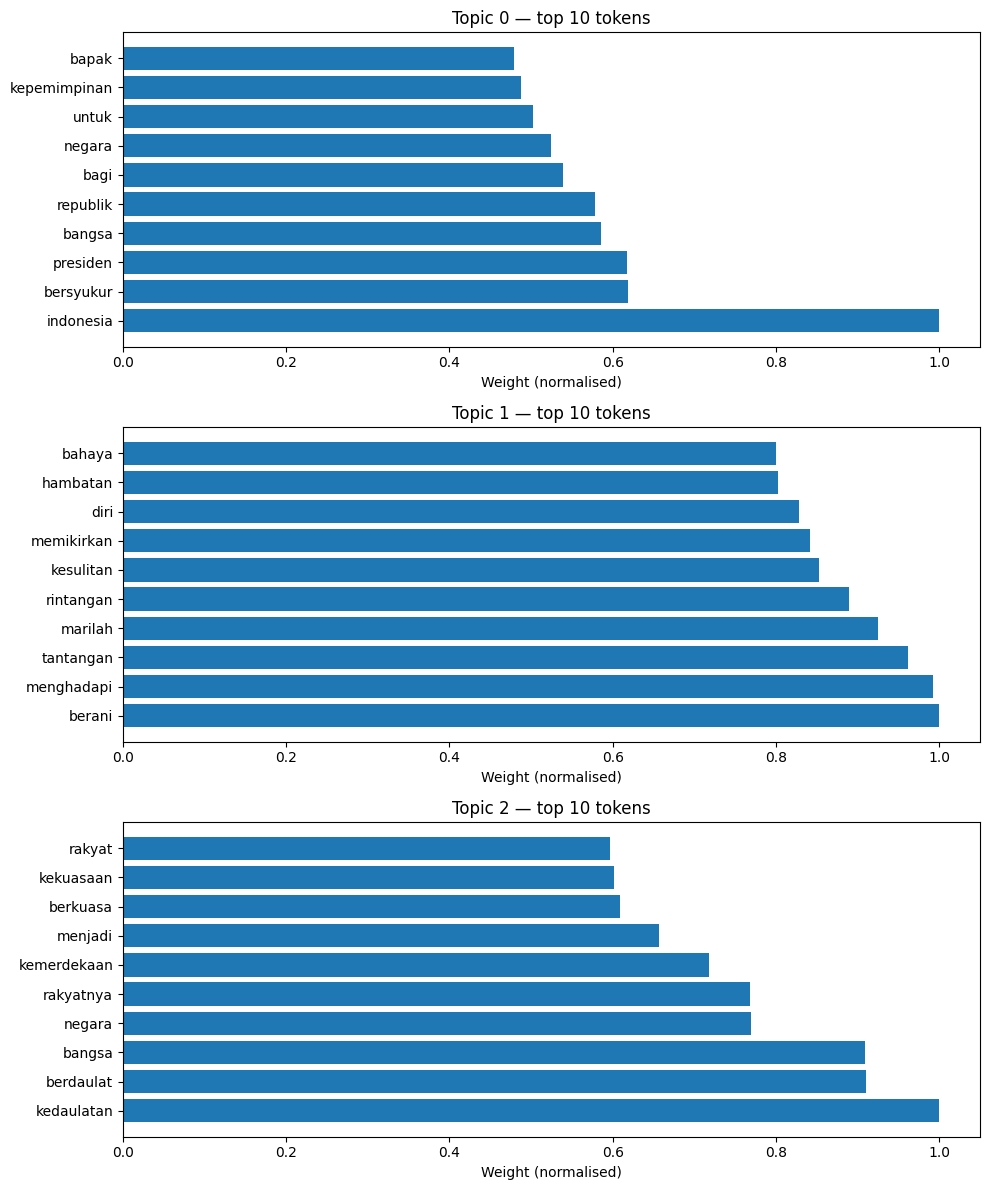

Plotted topic IDs: [0, 1, 2]


In [ ]:
def get_top_k_topic_ids(topic_model, k=3, exclude_outlier=True):
    info = topic_model.get_topic_info()  # columns typically: Topic, Count, Name, ...
    if exclude_outlier:
        info = info[info["Topic"] != -1]
    # “Top” = most documents assigned (Count)
    return info.sort_values("Count", ascending=False).head(k)["Topic"].tolist()

def plot_topics_single_image(topic_model, topic_ids=None, k=3, top_n_words=10,
                             normalise=True, figsize=(10, 12), savepath=None):
    """
    Plots multiple BERTopic topics in one image (stacked vertically).
    - topic_ids: e.g., [0, 3, 7]. If None, picks top-k by Count.
    - normalise: rescales each topic’s weights to [0, 1] (per-topic).
    - savepath: e.g. "top3_topics.png" to save the image.
    """
    if topic_ids is None:
        topic_ids = get_top_k_topic_ids(topic_model, k=k, exclude_outlier=True)

    n = len(topic_ids)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=figsize)
    if n == 1:
        axes = [axes]

    for ax, tid in zip(axes, topic_ids):
        pairs = topic_model.get_topic(tid)
        if not pairs:
            ax.set_title(f"Topic {tid} (empty)")
            ax.axis("off")
            continue

        pairs = pairs[:top_n_words]
        words, weights = zip(*pairs)

        if normalise:
            mx = max(weights)
            weights = [w / mx if mx != 0 else 0 for w in weights]

        # reverse so the highest-weight word appears at the top after invert_yaxis
        words = list(words)[::-1]
        weights = list(weights)[::-1]

        ax.barh(words, weights)
        ax.set_title(f"Topic {tid} — top {top_n_words} tokens")
        ax.set_xlabel("Weight" + (" (normalised)" if normalise else ""))
        ax.invert_yaxis()

    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")

    plt.show()
    return topic_ids

# Option 1: plot the top-3 topics by Count (recommended default)
top3 = plot_topics_single_image(topic_model_3, k=3, top_n_words=10, normalise=True,
                                figsize=(10, 12), savepath="top3_topics.png")
print("Plotted topic IDs:", top3)
